In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp

## Q1.
Use 2019 stock data ( stocks2019.csv  Download stocks2019.csv ) to find a portfolio that maximizes expected return while maintaining that no more than 100 days have a negative return.  Short selling is not allowed.  Apply this portfolio to 2020 data ( stocks2020.csv  Download stocks2020.csv ), how many days in 2020 had negative returns?

To solve this problem set your objective to be the mean return of your portfolio.  Then define a binary variable for each days' return that takes on the value 1 if that day's return is negative, and 0 if it's positive (enforce this with a big-M constraint) and then add a constraint that the sum of these binary variables must be less than or equal to 100.  This is an integer programming problem.

In [2]:
data_2019 = pd.read_csv('stocks2019.csv')
data_2020 = pd.read_csv('stocks2020-1.csv')

In [3]:
data_2019

,X,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
1,2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2,2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
3,2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
4,2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2019-12-23,8696.009766,58.505219,328.950012,45.459999,110.459999,278.140015,1350.630005,1348.839966,1793.000000,...,34.660000,253.020004,192.429993,148.814499,219.979996,56.759140,165.610001,61.401749,61.415092,97.683632
247,2019-12-24,8699.509766,58.425743,329.640015,46.540001,110.279999,277.890015,1344.430054,1343.560059,1789.209961,...,34.470001,252.490005,192.750000,148.436371,220.559998,56.545940,166.190002,60.941479,61.655396,97.278679
248,2019-12-26,8778.309570,58.505219,331.200012,46.630001,108.930000,278.260010,1362.469971,1360.400024,1868.770020,...,34.570000,251.330002,193.710007,148.098038,220.250000,57.078938,165.360001,61.499676,61.586739,97.466339
249,2019-12-27,8770.980469,58.803261,330.790009,46.180000,108.550003,277.640015,1354.640015,1351.890015,1869.800049,...,34.610001,253.169998,194.050003,147.849274,220.970001,57.195225,165.850006,60.843552,61.910412,97.209534


In [4]:
# function to provide returns from the prices
def get_returns(df):
    
    shift_df = df.shift(1)
    return_df = (df - shift_df)/shift_df
    return_df.dropna(inplace=True)
    
    return return_df

In [5]:
# printing numer of stocks and trading days
print('# of stocks', data_2019.shape[1]-2)
print('# of trading days', data_2019.shape[0])

# getting returns for index and stocks values for 2019
returns_2019 = get_returns(data_2019.iloc[:, 1:])
index_2019 = returns_2019[['NDX']].values
stocks_2019 = returns_2019.iloc[:, 1:].values
print(stocks_2019.shape)

# of stocks 100
# of trading days 251
(250, 100)


In [6]:
# printing numer of stocks and trading days
print('# of stocks', data_2020.shape[1]-2)
print('# of trading days', data_2020.shape[0])

# getting returns for index and stocks values for 2020
returns_2020 = get_returns(data_2020.iloc[:, 1:])
index_2020 = returns_2020[['NDX']].values
stocks_2020 = returns_2020.iloc[:, 1:].values

# of stocks 100
# of trading days 252


In [7]:
# positive return days
n_days_pos = 100

# getting total number of stocks
n = stocks_2019.shape[1]
print('# of stocks', n)

# getting total number of days
n_days = stocks_2019.shape[0]
print('# of days', n_days)

# of stocks 100
# of days 250


In [8]:
# creating avg return for each stock for optimal function
avg_return_2019 = np.mean(stocks_2019, 1)

In [118]:
# setting constraints matrix
A = np.zeros((2*n_days + 2, n + n_days))
b = np.zeros(2*n_days + 2)
sense = ['<']*(A.shape[0])
vtype = ['C']*n + ['B']*n_days
obj = np.zeros(A.shape[1])
lb = [0]*A.shape[1]
ub = [1]*A.shape[1]

# checking constraint matrix size
print('Shape of constraint matrix', A.shape)

Shape of constraint matrix (502, 350)


In [119]:
returns_2019.max().max()

0.27155174606686744

In [126]:
# setting first constraint for binary varibale
bigM = 1
for i in range(n_days):
    A[2*i, :n] = stocks_2019[i, :]
    A[2*i, n+i] = 1
    b[2*i] = 0
    sense[2*i] = '>'
    
    A[2*i+1, :n] = stocks_2019[i, :]
    A[2*i+1, n+i] = 1
    b[2*i+1] = bigM
    sense[2*i+1] = '<'
    
# second constraint
A[-2, :n] = 1
b[-2] = 1
sense[-2] = '='
    
# last constraint
A[-1, n:] = 1
b[-1] = 100

In [145]:
# setting objective
yearly_return = (data_2019.iloc[-1, 2:] - data_2019.iloc[0, 2:])/data_2019.iloc[0, 2:]
# obj[:n] = yearly_return.values
obj[:n] = stocks_2019.mean(axis=0)

In [146]:
# running the model
model = gp.Model()

modx = model.addMVar(A.shape[1], ub=ub, lb=lb, vtype=vtype)

mod_con = model.addMConstrs(A, modx, sense, b)

# setting the objective function
model.setMObjective(None, obj, 0, sense=gp.GRB.MAXIMIZE)

# restricting gurobi logs
model.Params.OutputFlag = 0

# optimizing the function
model.optimize()


In [240]:
model.x[:n]

[0.0,
 0.0,
 0.776156716545457,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02417055999479501,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01663170658250162,
 0.0006199707130187007,
 0.0,
 0.03675844139983354,
 0.0,
 0.0,
 0.033611349531429566,
 0.0,
 0.0,
 0.042692789639948325,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.64150200626612e-18,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0021241804390502994,
 0.0,
 0.0,
 0.045710726508083,
 0.0,
 0.021523558645882908,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.455598012248445e-18,
 0.0]

In [148]:
sum(model.x[n:])

100.0

In [149]:
weights = model.x[:n]
sum((stocks_2020 @ weights) < 0)

115

## Q2

You are the publisher for 5 local newspapers.  The previous 50 days worth of demand is included in the following file

hw2_demand.csv  Download hw2_demand.csv 

It costs you $0.50, $0.50, $0.25, $0.75, $0.25  to print each copy of each of the 5 newspapers.

The newspapers sell for $1.25, $1.20, $0.50, $1.50, $0.60 each.


Solve the multi-product newsvendor problem.

 
How much profits do you expect to make tomorrow?  Round to the nearest cent.

In [160]:
data = pd.read_csv('hw2_demand.csv')
data.head()

,X1,X2,X3,X4,X5
0,19,1358,95,65,4994
1,31,734,153,106,1711
2,45,732,198,348,205
3,1,57,64,89,278
4,180,316,277,176,46


In [161]:
data.shape

(50, 5)

In [190]:
p = [1.25, 1.20, 0.50, 1.50, 0.60]
c = [0.50, 0.50, 0.25, 0.75, 0.25]
n_newspaper = 5
n_days = 50

In [322]:
# setting constraints matrix
A = np.zeros((n_newspaper*2*n_days , n_newspaper*(n_days + 1)))
b = np.zeros(A.shape[1])
sense = ['<']*A.shape[0]
vtype = ['C']*A.shape[0]
obj = np.zeros(A.shape[1])

# checking constraint matrix size
print('Shape of constraint matrix', A.shape)

Shape of constraint matrix (500, 255)


In [329]:
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(A.shape[1])
obj[n_newspaper:] = 1/n_days

lb = np.zeros(A.shape[1])
lb[n_newspaper:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

rhs = np.zeros(A.shape[0])
direction = np.array(['<']*(A.shape[0]))

In [330]:
k = 0
row_idx = 0
for j in range(n_newspaper):
    col_start = n_newspaper + n_days*j
    for i in range(n_days):
        h_idx = col_start + i
        print(k, j, h_idx)
        
        A[k, [h_idx, j]] = [1, c[j]]
        rhs[k] = p[j]*data.iloc[i, j]
        
        A[k+1, [h_idx, j]] = [1, c[j] - p[j]]
        rhs[k+1] = 0
        
        k += 2

0 0 5
2 0 6
4 0 7
6 0 8
8 0 9
10 0 10
12 0 11
14 0 12
16 0 13
18 0 14
20 0 15
22 0 16
24 0 17
26 0 18
28 0 19
30 0 20
32 0 21
34 0 22
36 0 23
38 0 24
40 0 25
42 0 26
44 0 27
46 0 28
48 0 29
50 0 30
52 0 31
54 0 32
56 0 33
58 0 34
60 0 35
62 0 36
64 0 37
66 0 38
68 0 39
70 0 40
72 0 41
74 0 42
76 0 43
78 0 44
80 0 45
82 0 46
84 0 47
86 0 48
88 0 49
90 0 50
92 0 51
94 0 52
96 0 53
98 0 54
100 1 55
102 1 56
104 1 57
106 1 58
108 1 59
110 1 60
112 1 61
114 1 62
116 1 63
118 1 64
120 1 65
122 1 66
124 1 67
126 1 68
128 1 69
130 1 70
132 1 71
134 1 72
136 1 73
138 1 74
140 1 75
142 1 76
144 1 77
146 1 78
148 1 79
150 1 80
152 1 81
154 1 82
156 1 83
158 1 84
160 1 85
162 1 86
164 1 87
166 1 88
168 1 89
170 1 90
172 1 91
174 1 92
176 1 93
178 1 94
180 1 95
182 1 96
184 1 97
186 1 98
188 1 99
190 1 100
192 1 101
194 1 102
196 1 103
198 1 104
200 2 105
202 2 106
204 2 107
206 2 108
208 2 109
210 2 110
212 2 111
214 2 112
216 2 113
218 2 114
220 2 115
222 2 116
224 2 117
226 2 118
228 2 119
230 2

In [331]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

# spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 500 rows, 255 columns and 1000 nonzeros
Model fingerprint: 0x44ab24b6
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [2e-02, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 250 rows and 0 columns
Presolve time: 0.01s
Presolved: 250 rows, 255 columns, 500 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4081840e+03   7.040920e+04   0.000000e+00      0s
     115    3.3698900e+02   0.000000e+00   0.000000e+00      0s

Solved in 115 iterations and 0.01 seconds
Optimal objective  3.369890000e+02


In [332]:
spMod.objVal

336.9890000000003

## Q3
Go back to the saving for retirement problem we did in class.  There's approximately a 55% chance you go bankrupt before you die.  That's not very good.  You should probably keep working for a few more years.  Today you have $2M in your retirement account.  If you keep working, you earn $400k (after taxes) per year, with a 2.5% raise every year.  You still spend $150k per year and when you work, every dollar of salary that you don't spend goes into your retirement account. As in the code from class, each year first grow your portfolio from market returns, then add your salary and give yourself a raise for next year (if you're still working), then subtract your cost of living. You're still going to die 35 years from today.  The market has normal annual returns with mean = 7% and sd = 10%.  What is the smallest number of years you need to work such that your probability of going bankrupt before death is less than 6%?  Use 10000 simulations.

In [98]:
nsim = 10000
n_years = 35
def_vec_rd = np.zeros((n_years, nsim))
port_val_vec_rd = np.zeros((n_years, nsim))

job_till = n_years
for y in range(n_years):
    for sim in range(nsim):
        salary = 400000
        increment = 0.025
        value = 2000000
        death = 35
        for year in range(death):
            port_return = np.random.normal(size = 1, loc = 0.07, scale = 0.1)
            value = value*(1+port_return)
            
            if job_till > year:
                salary = salary*(1+increment)
                value += salary
                
            value = value - 150000
            if (value <= 0):
                value = 0
        if value <= 0:
            def_vec_rd[y, sim] = 1
        port_val_vec_rd[y, sim] = value
    job_till -= 1

In [107]:
def_vec_rd.mean(axis=1) 
# he need to work for 3 more years

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e-04, 2.000e-04, 1.100e-03, 1.400e-03,
       6.400e-03, 1.850e-02, 4.680e-02, 1.287e-01, 2.855e-01])

(array([9., 8., 9., 3., 2., 3., 0., 0., 0., 1.]),
 array([5.95054278e+06, 2.29051827e+07, 3.98598225e+07, 5.68144624e+07,
        7.37691023e+07, 9.07237422e+07, 1.07678382e+08, 1.24633022e+08,
        1.41587662e+08, 1.58542302e+08, 1.75496942e+08]),
 <BarContainer object of 10 artists>)

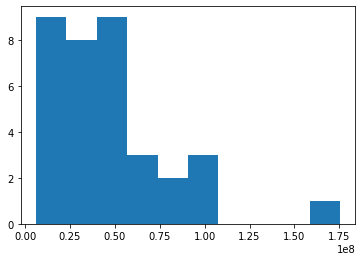

In [151]:
import matplotlib.pyplot as plt
plt.hist(port_val_vec_rd[:, -1])

## Q4

You manufacture microprocessors.  There are 2 lines of chips: high performance and low performance.  Your manufacturing processes are not perfect though, there are quality issues in your production. There are 2 manufacturing processes you can perform.  One process produces chips where the performance is a normal random variable with mean = 10 and sd = 3, and it costs $ 10 to manufacture chips using this process.  The other manufacturing process produces chips where the performance is a normal random variable with mean = 5 and sd = 2, and it costs $ 5 to manufacture chips using this process.  Any chip that has a performance less than 7 must be sold as a low performance chip, and any chip that has a performance above 7 can be sold as a high performance chip.  Low performance chips sell for $ 8 and high performance chips sell for $ 15.  There is currently a global chip shortage, so any chip you manufacture will sell immediately.  If you produce 100 chips using the first process and 200 chips using the second process, what is the standard deviation of your profit?  Use 10000 simulations to answer this question.

In [152]:
def get_profit(pp1, pp2):
    cost = pp1.shape[0]*10 + pp2.shape[0]*5
    
    rev_pp1 = np.sum(pp1 < 7)*8 + np.sum(pp1 >= 7)*15
    rev_pp2 = np.sum(pp2 < 7)*8 + np.sum(pp2 >= 7)*15
    
    profit = rev_pp1 + rev_pp2 - cost
    
    return profit



In [154]:
n_sim = 10000
profit_list = np.zeros(n_sim)

for s in range(n_sim):
    pp1 = np.random.normal(size=100, loc=10, scale=3)
    pp2 = np.random.normal(size=200, loc=5, scale=2)
    
    profit_list[s] = get_profit(pp1, pp2)

(array([   7.,  101.,  590., 1785., 2928., 2731., 1389.,  393.,   70.,
           6.]),
 array([1044. , 1078.3, 1112.6, 1146.9, 1181.2, 1215.5, 1249.8, 1284.1,
        1318.4, 1352.7, 1387. ]),
 <BarContainer object of 10 artists>)

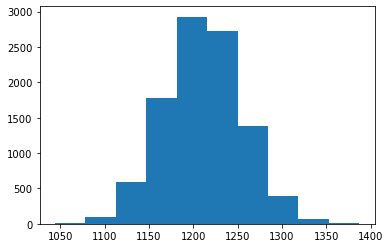

In [156]:
plt.hist(profit_list)

In [159]:
print('Mean is', profit_list.mean())
print('Standard deviation is', profit_list.std())

Mean is 1211.0242
Standard deviation is 44.30749388489492
